# $\hat{\Omega_m} = \Omega_b \frac{\hat{M_{\rm tot}}}{\hat{M_{\rm b}}}$

In [1]:
import h5py 
import numpy as np 
from tqdm import tqdm

In [2]:
import torch
from sbi import utils as Ut
from sbi import inference as Inference

In [3]:
from goleta import nns as NNs

In [4]:
import corner as DFM

# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [5]:
seed = 1
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)
    kwargs = {'num_workers': 4, 'pin_memory': True}
else:
    kwargs = {}

In [6]:
ftng = h5py.File('/Users/chahah/data/goleta/tng.snap33.subfind.galaxies.LHC.hdf5', 'r')
# Om, s8, Asn1, Aagn1, Asn2, Aagn2, Mg, Mstar, Mbh, Mtot, Vmax, Vdisp, Zg, Zs, SFR, J, Vel, Rstar, Rtot, Rvmax,
# absmag U, B, V, K, g, r, i, z
tng = ftng['props'][...]

w_tng = np.loadtxt('/Users/chahah/data/goleta/camels_tng.omega_thetag.dat', unpack=True, usecols=[-1])

# restrict only to centrals
is_central = np.loadtxt('/Users/chahah/data/goleta/tng.snap33.subfind.galaxies.LHC.iscen')
is_central = is_central.astype(bool)

tng = tng[:,is_central]
w_tng = w_tng[is_central]

is_sf = (np.log10(tng[14])-np.log10(tng[7]) > -10.)

/opt/anaconda3/envs/uhod/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


In [7]:
high_baryons = (tng[6] + tng[7]) / tng[9] > 0.9
print('%.2f have >90 percent baryons' % np.mean(high_baryons))

0.03 have >90 percent baryons


# $\hat{M}_{\rm tot} ( V_{\rm max}, M_*, R_*)$

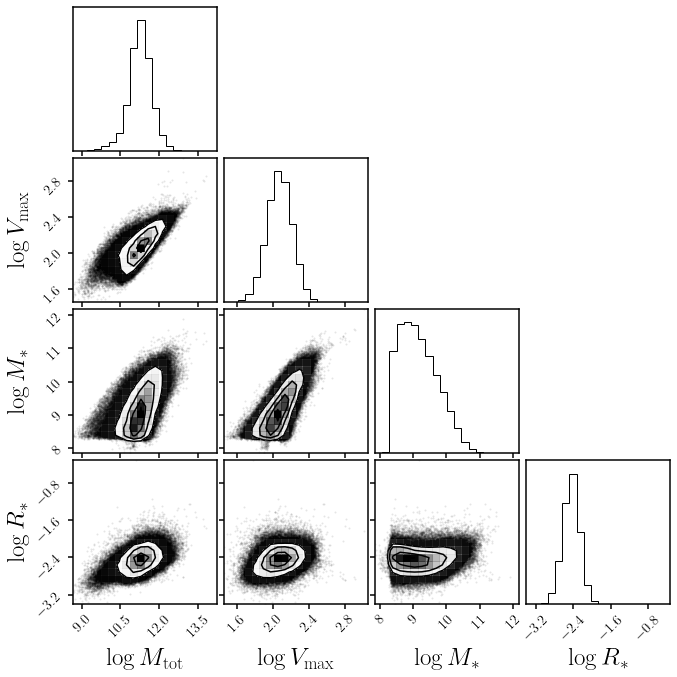

In [8]:
fig = DFM.corner(np.array([np.log10(tng[9]), np.log10(tng[10]), np.log10(tng[7]), np.log10(tng[17])]).T[is_sf & ~high_baryons], 
                labels=[r'$\log M_{\rm tot}$', r'$\log V_{\rm max}$', r'$\log M_*$', r'$\log R_*$'], label_kwargs={'fontsize': 25})

In [9]:
Y = np.log10(tng[9])[is_sf & ~high_baryons]
X = np.array([np.log10(tng[10]), np.log10(tng[7]), np.log10(tng[17])]).T[is_sf & ~high_baryons]

In [10]:
Ntrain = int(0.9 * X.shape[0])
Nvalid = int(0.1 * X.shape[0])

ishuffle = np.arange(X.shape[0])
np.random.shuffle(ishuffle)

In [11]:
prior = Ut.BoxUniform(low=torch.tensor([8.5]), high=torch.tensor([14]))

In [ ]:
nhidden = 128
nblocks = 5

anpe = Inference.SNPE(prior=prior, 
                      density_estimator=Ut.posterior_nn('maf', hidden_features=nhidden, num_transforms=nblocks))
anpe.append_simulations(torch.tensor(Y[ishuffle][:Ntrain][:,None]), torch.tensor(X[ishuffle][:Ntrain]))

p_y_x_estimator = anpe.train()
hat_Mtot = anpe.build_posterior(p_y_x_estimator)

/opt/anaconda3/envs/uhod/lib/python3.7/site-packages/sbi/neural_nets/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Training neural network. Epochs trained: 5

In [ ]:
ranks, mu_y, sig_y = [], [], []
for _x, _y in tqdm(zip(X[ishuffle][Ntrain:Ntrain+1000], Y[ishuffle][Ntrain:Ntrain+1000])):
    # sample posterior p(theta | x_test_i)
    y_prime = hat_Mtot.sample((1000,), 
            x=torch.as_tensor(_x.astype(np.float32)).to(device), 
            show_progress_bars=False)
    y_prime = np.array(y_prime.detach().cpu())

    # calculate percentile score and rank
    ranks.append(np.mean(y_prime < _y))
    mu_y.append(np.mean(y_prime))
    sig_y.append(np.std(y_prime))

In [ ]:
fig = plt.figure(figsize=(6,4))
sub = fig.add_subplot(111)
_ = sub.hist(ranks, range=(0., 1), bins=20, histtype='step', linewidth=2, density=True)
sub.plot([0., 1.], [1., 1.], c='k', ls='--')
sub.set_xlim(0., 1.)
sub.set_yticks([])

In [ ]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(Y[ishuffle][Ntrain:Ntrain+1000], mu_y, c='C0', s=1)
#sub.errorbar(Y[ishuffle][Ntrain:Ntrain+1000], mu_y, yerr=sig_y, fmt='.C0')
sub.set_xlabel(r'$\log M_{\rm tot}$', fontsize=25)
sub.set_xlim(8.5, 13.5)
sub.set_ylabel(r'$\log \hat{M}_{\rm tot}$', fontsize=25)
sub.set_ylim(8.5, 13.5)

# $\hat{\epsilon}_*(M_*, Z_*)$

In [ ]:
epsilon_star = (tng[0]/0.049) * (tng[7]/tng[9])

In [ ]:
fig = DFM.corner(np.array([np.log10(epsilon_star), np.log10(tng[7]), np.log10(tng[13]), np.log10(tng[17]), np.log10(tng[2])]).T[is_sf & ~high_baryons], 
                labels=[r'$\log \epsilon_*$', r'$\log M_*$', r'$\log Z_*$', r'$\log R_*$', r'$\log A_{\rm SN1}$'], label_kwargs={'fontsize': 25})